# LAB 2: Random high-dimensional representation of structured data, Self-Organizing Maps and Back Propagation

## Part 1

### Task 1.1

In [31]:
import datasets
from datasets import load_dataset, concatenate_datasets
import numpy as np

# Many of the 21 corpora have sizes: 10K, 30K, 100K, 300K, 1M but not all of them
# All except Slovak was available for 2019
# Change the ids below to try different sizes or years
data_ids = [
    "bul_news_2019_10K",
    "ces_news_2019_10K",
    "dan_news_2019_10K",
    "deu_news_2019_10K",
    "ell_news_2019_10K",
    "eng_news_2019_10K",
    "est_news_2019_10K",
    "fin_news_2019_10K",
    "fra_news_2019_10K",
    "hun_news_2019_10K",
    "ita_news_2019_10K",
    "lav_news_2019_10K",
    "lit_news_2019_10K",
    "nld_news_2019_10K",
    "pol_news_2019_10K",
    "por_news_2019_10K",
    "ron_news_2019_10K",
    "slk_news_2020_10K",
    "slv_news_2019_10K",
    "spa_news_2019_10K",
    "swe_news_2019_10K"
]

language_map = {
    "bul": "Bulgarian",
    "ces": "Czech",
    "dan": "Danish",
    "deu": "German",
    "ell": "Greek",
    "eng": "English",
    "est": "Estonian",
    "fin": "Finnish",
    "fra": "French",
    "hun": "Hungarian",
    "ita": "Italian",
    "lav": "Latvian",
    "lit": "Lithuanian",
    "nld": "Dutch",
    "pol": "Polish",
    "por": "Portuguese",
    "ron": "Romanian",
    "slk": "Slovak",
    "slv": "Slovenian",
    "spa": "Spanish",
    "swe": "Swedish"
}

def get_multi_language_dataset(data_ids):
    
    datasets = []
    
    for data_id in data_ids:
        ds = load_dataset("imvladikon/leipzig_corpora_collection", data_id, split="train", trust_remote_code=True)
        language_code = data_id.split('_')[0]
        label = language_map[language_code]
        ds = ds.add_column("label", [label] * len(ds))
        datasets.append(ds)

    full_dataset = concatenate_datasets(datasets)

    return full_dataset

full_ds = get_multi_language_dataset(data_ids)

# dataset information
print("Dataset info: ", full_ds)
print("Dataset shape: ", full_ds.shape)
print("Labels: ", set(full_ds["label"]))
print("Sample data: ", full_ds["sentence"][:1], full_ds["label"][:1])

Dataset info:  Dataset({
    features: ['id', 'sentence', 'label'],
    num_rows: 184591
})
Dataset shape:  (184591, 3)
Labels:  {'Danish', 'German', 'English', 'Dutch', 'Spanish', 'Portuguese', 'Polish', 'French', 'Greek', 'Lithuanian', 'Slovak', 'Italian', 'Finnish', 'Czech', 'Estonian', 'Bulgarian', 'Swedish', 'Hungarian', 'Romanian', 'Slovenian', 'Latvian'}
Sample data:  ['1975 бяха победи в категорията "най-добра британска група" и спечели най-голямата награда на снощната церемония в Лондон - "най-добър албум", за "A Brief Inquiry into Online Relationships".'] ['Bulgarian']


In [2]:
## Preprocessing to remove punctuation and keep only words in lowercase
import regex as re   
word_pattern = re.compile(r"\p{L}+", flags=re.UNICODE) ## regex used to match and find words in the documents regardless of language

preprocessed_db = {"words": [], "labels": []}  ## create a new db for words and their corresponding labels
preprocessed_db_by_language = {full_language_name: [] for full_language_name in language_map.values()} ## create a new db for each language
for item in full_ds:
    label = item["label"]
    text = item["sentence"]
    words = word_pattern.findall(text) ## extract words using regex
    words = [word.lower() for word in words] ## convert to lowercase
    preprocessed_db["words"].extend(words)
    preprocessed_db["labels"].extend([label] * len(words))
    preprocessed_db_by_language[label].extend(words)
        
## testing the preprocessed db
print(f"preprocessed_db sample for words: {preprocessed_db['words'][:10]} with the labels: {preprocessed_db['labels'][:10]}")
print(f"preprocessed_db keys : {preprocessed_db.keys()}")

print(f"number of english words: {preprocessed_db['labels'].count('English')}")

preprocessed_db sample for words: ['бяха', 'победи', 'в', 'категорията', 'най', 'добра', 'британска', 'група', 'и', 'спечели'] with the labels: ['Bulgarian', 'Bulgarian', 'Bulgarian', 'Bulgarian', 'Bulgarian', 'Bulgarian', 'Bulgarian', 'Bulgarian', 'Bulgarian', 'Bulgarian']
preprocessed_db keys : dict_keys(['words', 'labels'])
number of english words: 194795


In [3]:
from sklearn.model_selection import train_test_split

## typical split is 70% train, 15% val, 15% test
X_train, X_test, y_train, y_test = train_test_split(preprocessed_db["words"], preprocessed_db["labels"], test_size=0.2, random_state=42, stratify=preprocessed_db["labels"])

X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

## Checking the sizees of the train and test splits
print("Training set size: ", len(X_train))
print("Validation set size: ", len(X_val))
print("Test set size: ", len(X_test))
print("Training labels distribution: ", {label: y_train.count(label) for label in set(y_train)})



Training set size:  1944753
Validation set size:  833466
Test set size:  694555
Training labels distribution:  {'Danish': 95516, 'German': 84237, 'Dutch': 80303, 'English': 109085, 'Spanish': 126573, 'Portuguese': 107653, 'Polish': 74518, 'French': 112750, 'Greek': 105295, 'Lithuanian': 78787, 'Slovak': 84810, 'Italian': 108342, 'Finnish': 62280, 'Czech': 77172, 'Estonian': 80750, 'Bulgarian': 83226, 'Swedish': 82890, 'Hungarian': 92169, 'Romanian': 105968, 'Slovenian': 100746, 'Latvian': 91683}


In [4]:
from pathlib import Path
import re


## Map language codes to names for better understanding
language_map_test = {
    "en": "English",
    "fr": "French",
    "et": "Estonian",
    "sv": "Swedish",
    "ro": "Romanian",
    "it": "Italian",
    "da": "Danish"
}

languages_path_list = list(Path("./Test_dataset").rglob("*"))

selected_languages = {}
for path in languages_path_list:
    if path.is_dir():
        continue
    lang = path.suffix.lstrip(".")
    if lang in language_map_test and lang not in selected_languages:
        selected_languages[lang] = path

print("Selected files:", selected_languages)

## Dictionary to hold all of the sampled data 
Final_test_db = {}
word_pattern = re.compile(r"[a-zA-ZÀ-ÿ]+")

N_WORDS = 5000  ## number of words per language

for lang_code, file_path in selected_languages.items():

    lang_name = language_map_test[lang_code]   # "Danish", "English", e

    samples = []

    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            ## lowercase and extract words (remove punctuation/numbers)
            words = word_pattern.findall(line.lower())

            samples.extend(words)

            if len(samples) >= N_WORDS:
                samples = samples[:N_WORDS]
                break
        Final_test_db[lang_name] = samples



Selected files: {'en': PosixPath('Test_dataset/da-en/europarl-v7.da-en.en'), 'da': PosixPath('Test_dataset/da-en/europarl-v7.da-en.da'), 'et': PosixPath('Test_dataset/et-en/europarl-v7.et-en.et'), 'sv': PosixPath('Test_dataset/sv-en/europarl-v7.sv-en.sv'), 'fr': PosixPath('Test_dataset/fr-en/europarl-v7.fr-en.fr'), 'it': PosixPath('Test_dataset/it-en/europarl-v7.it-en.it'), 'ro': PosixPath('Test_dataset/ro-en/europarl-v7.ro-en.ro')}


In [5]:
print("Final test dataset size: ", len(Final_test_db))
print("Final test dataset labels: ", set(Final_test_db.keys()))
print("Number of words per language sample: ", {lang: len(words) for lang, words in Final_test_db.items()})
print(Final_test_db["English"][:10])

Final test dataset size:  7
Final test dataset labels:  {'French', 'Danish', 'Romanian', 'English', 'Swedish', 'Italian', 'Estonian'}
Number of words per language sample:  {'English': 5000, 'Danish': 5000, 'Estonian': 5000, 'Swedish': 5000, 'French': 5000, 'Italian': 5000, 'Romanian': 5000}
['resumption', 'of', 'the', 'session', 'i', 'declare', 'resumed', 'the', 'session', 'of']


In [6]:
test = "ac"
test = test + "bd"
print("Test list: ", test)
print("Test list as list: ", list(test))

Test list:  acbd
Test list as list:  ['a', 'c', 'b', 'd']


### Task 1.2

In [7]:
## for english language sample

english_sample = ""
d = 100  ## dimension of encoding
possible_encoding_values = [-1,1]
for word,label in zip(X_train, y_train):
    if label == "English":
        english_sample += word
        
a = np.unique(list(english_sample))
encoding_words = {char: np.random.choice(possible_encoding_values, size=d) for char in a}
n = 3

n_grams = []

for i in range(len(english_sample) - n + 1):
    gram = tuple(english_sample[i:i+n])   
    if i==2:
        print("Sample n-gram at position 2: ", gram)
    n_grams.append(gram)

        
s = {n_gram : 0 for n_gram in n_grams}

for n_gram in n_grams:
    s[n_gram] += 1
    

def rotate(vec, shift):
    """Cyclic permutation / circular shift"""
    return np.roll(vec, shift)

def bind(vectors):
    """Elementwise multiplication"""
    v = vectors[0]
    for x in vectors[1:]:
        v = v * x
    return v
   
encoded_n_grams = {}

for gram in n_grams:
    w1, w2, w3 = gram

    v1 = encoding_words[w1]
    v2 = rotate(encoding_words[w2], 1)   # rotate by 1
    v3 = rotate(encoding_words[w3], 2)   # rotate by 2

    hd_vec = bind([v1, v2, v3])
    ## encode each n gram as a HD vector
    encoded_n_grams[gram] = hd_vec


S = np.zeros(d)

for gram, count in s.items():
    S += count * encoded_n_grams[gram]
S = S / np.linalg.norm(S)

print("Final HD n-gram representation S:", S)

Sample n-gram at position 2:  ('p', 'e', 'a')
Final HD n-gram representation S: [-0.00497746  0.15176216 -0.02732556 -0.05391531 -0.00320289  0.03935803
  0.00441479 -0.05078456  0.15379642 -0.17996778  0.07445998  0.15780725
 -0.04143558 -0.05496852  0.12924093 -0.11133649 -0.00242381  0.04274848
  0.09578372  0.1021895  -0.06385581 -0.16085144  0.16705523 -0.01891436
 -0.16246731  0.07345006  0.17588482  0.03640041 -0.11152405 -0.25917439
  0.03062944 -0.10305515  0.09288381  0.18185778 -0.06072506 -0.16996957
  0.10524812  0.09110923 -0.04991891  0.17957824 -0.10053034 -0.12752407
  0.12939964  0.10270889  0.05397302 -0.10912909 -0.11339961  0.02705143
  0.1124474   0.05972957 -0.10748437  0.00359243 -0.04095948  0.04055551
  0.04313802 -0.05557447  0.05537248  0.09625983 -0.01359064 -0.08627604
  0.01907306 -0.0363427   0.0281912  -0.02706586 -0.08657902 -0.03334179
 -0.22965586 -0.0056267  -0.09703891 -0.04235894 -0.02827777 -0.02638777
 -0.01438415 -0.0457061  -0.07433013 -0.1584

In [ ]:
from collections import Counter

def HD_embedding(words, labels, d):
    # ---- Build shared character encoding ----
    all_text = "".join(words)
    chars = np.unique(list(all_text))
    encoding_chars = {c: np.random.choice([-1,1], size=d) for c in chars}
    
    # ---- Build text per language ----
    languages_samples = {lang: "" for lang in set(labels)}
    for w, l in zip(words, labels):
        languages_samples[l] += w

    HD_embedding_language = {}

    for lang, text in languages_samples.items():
        # Compute tri-grams
        n = 3
        ngrams = [tuple(text[i:i+n]) for i in range(len(text)-2)]

        # Count them
        counts = Counter(ngrams)

        # Encode n-grams
        encoded = {}
        for gram in counts:
            v1 = encoding_chars[gram[0]]
            v2 = rotate(encoding_chars[gram[1]], 1)
            v3 = rotate(encoding_chars[gram[2]], 2)
            encoded[gram] = bind([v1, v2, v3])

        # Sum + normalize
        S = np.zeros(d)
        for gram, cnt in counts.items():
            S += cnt * encoded[gram]
        S /= np.linalg.norm(S)

        HD_embedding_language[lang] = S

    return HD_embedding_language


HD_embeddings_100 = HD_embedding(X_train, y_train, d=100)
print("HD Embeddings for languages: ", HD_embeddings_100.keys())
HD_embeddings_1000 = HD_embedding(X_train, y_train, d=1000)
print("HD Embeddings for languages (d=1000): ", HD_embeddings_1000.keys())

HD Embeddings for languages:  dict_keys(['Danish', 'German', 'Dutch', 'English', 'Spanish', 'Portuguese', 'Polish', 'French', 'Greek', 'Lithuanian', 'Slovak', 'Italian', 'Finnish', 'Czech', 'Estonian', 'Bulgarian', 'Swedish', 'Hungarian', 'Romanian', 'Slovenian', 'Latvian'])
HD Embeddings for languages (d=1000):  dict_keys(['Danish', 'German', 'Dutch', 'English', 'Spanish', 'Portuguese', 'Polish', 'French', 'Greek', 'Lithuanian', 'Slovak', 'Italian', 'Finnish', 'Czech', 'Estonian', 'Bulgarian', 'Swedish', 'Hungarian', 'Romanian', 'Slovenian', 'Latvian'])


Question : what will be the size of the n-gram input vector in conventional (local)
representation?

For n grams, the one hot vector has the dimension corresponding to every possible n gram meaning :
$$
size = a^n
$$
with $a$ = alphabet size and $n$ = length of n gram


In [9]:
alphabet_sizes = {lang : 0 for  lang in HD_embeddings_100.keys()}
languages_samples = {}
for word, label in zip(X_train, y_train):
    if label not in languages_samples:
        languages_samples[label] = ""
    languages_samples[label] += word
    
for lang in languages_samples:
    alphabet_sizes[lang] = len( np.unique( list(languages_samples[lang]) ) )
print("Alphabet sizes per language: ", alphabet_sizes)

Alphabet sizes per language:  {'Romanian': 56, 'Dutch': 50, 'French': 54, 'Polish': 59, 'Spanish': 44, 'Greek': 71, 'Bulgarian': 65, 'Lithuanian': 41, 'Estonian': 46, 'Slovak': 49, 'Slovenian': 47, 'Latvian': 45, 'Danish': 46, 'Portuguese': 53, 'Czech': 55, 'Hungarian': 55, 'German': 51, 'Italian': 43, 'Finnish': 48, 'English': 53, 'Swedish': 41}


In [10]:
for lang, alphabet_size in alphabet_sizes.items():
    print(f"Language: {lang}, n gram vector size: {alphabet_size**n}")
    

Language: Romanian, n gram vector size: 175616
Language: Dutch, n gram vector size: 125000
Language: French, n gram vector size: 157464
Language: Polish, n gram vector size: 205379
Language: Spanish, n gram vector size: 85184
Language: Greek, n gram vector size: 357911
Language: Bulgarian, n gram vector size: 274625
Language: Lithuanian, n gram vector size: 68921
Language: Estonian, n gram vector size: 97336
Language: Slovak, n gram vector size: 117649
Language: Slovenian, n gram vector size: 103823
Language: Latvian, n gram vector size: 91125
Language: Danish, n gram vector size: 97336
Language: Portuguese, n gram vector size: 148877
Language: Czech, n gram vector size: 166375
Language: Hungarian, n gram vector size: 166375
Language: German, n gram vector size: 132651
Language: Italian, n gram vector size: 79507
Language: Finnish, n gram vector size: 110592
Language: English, n gram vector size: 148877
Language: Swedish, n gram vector size: 68921


Question 2

As we can notice, the dimensionality explodes for certain languages making the feature vectores huge and therefore the computational and memory management complicated. One hot encoding also doesn't allow compositionaly meaning combining features or binding structures. It also isn't robust against noise. 

### Task 1.3

In [29]:
HD_embeddings_100_validation = HD_embedding(X_train, y_train, d=100)
HD_embeddings_1000_validation = HD_embedding(X_val, y_val, d=1000)


/home/matt/miniconda3/envs/appliedAI/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/home/matt/miniconda3/envs/appliedAI/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
/home/matt/miniconda3/envs/appliedAI/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/home/matt/miniconda3/envs/appliedAI/lib/python3

0.0


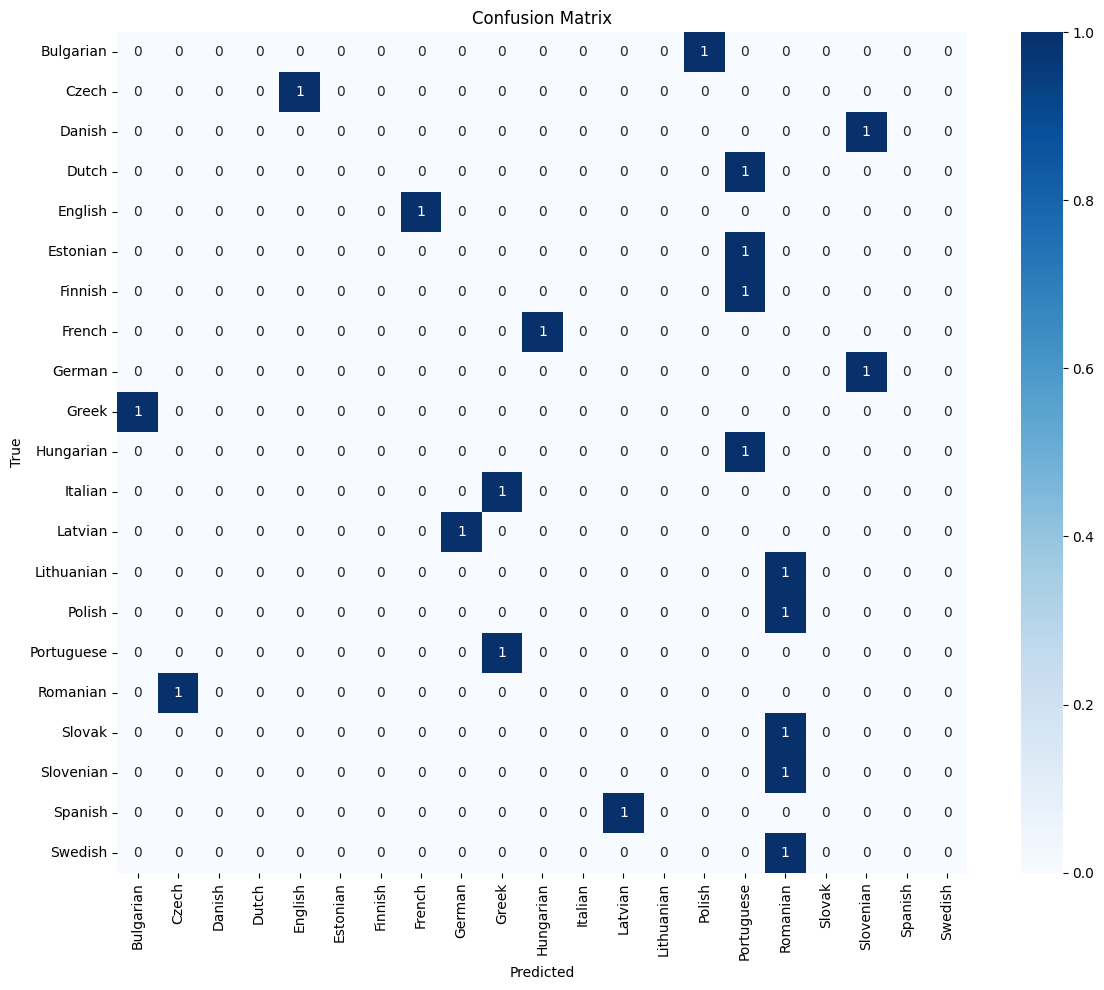

In [30]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics.pairwise import cosine_similarity 
import matplotlib.pyplot as plt
import seaborn as sns

def find_closest_language(HD_embedding_language_ref, HD_embedding_language_target):
    distances = {lang: 0 for lang in HD_embedding_language_ref.keys()}
    for lang_ref, vec_ref in HD_embedding_language_ref.items():
        distances[lang_ref] = cosine_similarity(vec_ref.reshape(1, -1), HD_embedding_language_target.reshape(1, -1))[0][0]
    closest_language = max(distances, key=distances.get)
    return closest_language, distances[closest_language]

true_labels = list(HD_embeddings_100_validation.keys())
predictions = []

for lang, hd_vec in HD_embeddings_100_validation.items():
    pred, _ = find_closest_language(HD_embeddings_100, hd_vec)
    predictions.append(pred)

F1_score = f1_score(true_labels, predictions, average="macro")
print(F1_score)
labels_sorted = sorted(HD_embeddings_100.keys())
cm = confusion_matrix(true_labels, predictions, labels=labels_sorted)

# --- PLOT HEATMAP ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()